# 3.2) If a transaction cannot be formed, whether it occurs on the weekend 

## Imports, Global Variables, and Global Functions/Classes

In [32]:
""" Imports """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import auc



""" Global Variables """

SEED = 42
CV_SPLITS = 5
CSV_PATH = "business analysis case study (1).csv" 

""" Global Functions/Classes """

# Sets the random seed
def set_seed():
    np.random.seed(SEED)

# Reads in the data
def load_business_data(): 
    return pd.read_csv(CSV_PATH)

# Applies the given threshold to convert the result into 0s and 1s
def apply_threshold(data, threshold):
    new_data = []
    for i in data:
        if i < threshold:
            new_data.append(0)
        else:
            new_data.append(1)
    return new_data

# Finds the result with the maximum f1 value, given a list
def find_max_f1(results_list):
    max_f1 = (0, 0)
    for result in results_list:
        if result.f1() > max_f1[0]:
            max_f1 = (result.f1(), result)
    return max_f1[1]

# Finds the result with the best roc co-ordinate value, given a list
def find_best_roc(results_list):
    best_roc = (0, 0)
    for result in results_list:
        if result.roc() > best_roc[0]:
            best_roc = (result.roc(), result)
    return best_roc[1]

# Plots all ROC co-ordinates
def plot_roc_comparison(title, ho_results, cv_results):
    fig = plt.figure()
    ax = fig.add_subplot()

    # Plots cross validation co-ordinates
    cv_data_x = []
    cv_data_y = []
    for result in cv_results:
        cv_data_x.append(result.fpr())
        cv_data_y.append(result.tpr())
    cv = ax.plot(cv_data_x, cv_data_y, marker = "o", markersize=2, color="r", label="Cross Validation", linestyle="None")
    
    # Plots holdout co-ordinates
    ho_data_x = []
    ho_data_y = []
    for result in ho_results:
        ho_data_x.append(result.fpr())
        ho_data_y.append(result.tpr())     
    ho = ax.plot(ho_data_x, ho_data_y, marker = "o", markersize=2, color="b", label="Holdout", linestyle="None")
    
    # Calculates AUC
    all_x = cv_data_x + ho_data_x
    all_y = cv_data_y + ho_data_y
    all_zipped = sorted(zip(all_x, all_y))
    all_auc = auc([i[0] for i in all_zipped], [i[1] for i in all_zipped])
    
    # Adds graph cosmetics
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(handles=[cv[0], ho[0]], loc="lower right")
    plt.title("ROC Curve for\n" + title)
    plt.plot([0, 1], [0, 1], color="k", linestyle="dashed", linewidth=1)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()
    plt.show()
    
    return all_auc
    
    
# A class used to store results of a single model
class Results:
    def __init__(self, name, model, cm):
        self.name = name
        self.model = model
        self.tn = cm[0][0]
        self.fp = cm[0][1]
        self.fn = cm[1][0]
        self.tp = cm[1][1]
        self.total = cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
    
    def tpr(self):
        return self.recall()
    
    def fpr(self):
        return 1-self.specificity()
    
    def roc(self):
        return self.tpr() - self.fpr()
    
    def accuracy(self):
        return (self.tp + self.tn)/(self.tp + self.tn + self.fp + self.fn)

    def precision(self):
        # If denominator is 0, return 0
        if self.tp + self.fp == 0:
            return 0
        else:
            return (self.tp)/(self.tp + self.fp)
    
    def sensitivity(self):
        # If denominator is 0, return 0
        if self.tp + self.fp == 0:
            return 0
        else:
            return (self.tp)/(self.tp + self.fn)
    
    def recall(self):
        return self.sensitivity()
        
    def specificity(self):
        # If denominator is 0, return 0
        if self.tn + self.fp == 0:
            return 0
        else:
            return (self.tn)/(self.tn + self.fp)
        
    def f1(self):
        # If denominator is 0, return 0
        if self.precision() + self.recall() == 0:
            return 0
        else:
            return (2*self.precision()*self.recall())/(self.precision() + self.recall())
    
    # Prints out a summary of the results
    def summary(self):
        print(self.name)
        print()
        print("TP:", round(self.tp, 3))
        print("FN:", round(self.fn, 3))
        print("TN:", round(self.tn, 3))
        print("FP:", round(self.fp, 3))
        print()
        print("TPR:", round(self.tpr(), 3))
        print("FPR:", round(self.fpr(), 3))
        print()
        print("Accuracy:", round(self.accuracy(), 3))
        print("Precision:", round(self.precision(), 3))
        print("Sensitivity/Recall:", round(self.recall(), 3))
        print("Specificity:", round(self.specificity(), 3))
        print("F1:", round(self.f1(), 3))
        print()

## Load In and Clean Data

In [33]:
data = load_business_data()

# "CustomerType" and "Weekend" should be encoded as 1s and 0s
data["CustomerType"] = np.where(data["CustomerType"] == "Returning_Customer", 1, 0)
data["Weekend"] = np.where(data["Weekend"] == True, 1, 0)

# These columns should be one-hot encoded
month_one_hot = pd.get_dummies(data["Month"])
data = data.drop("Month", axis=1)
data = data.join(month_one_hot)

special_one_hot = pd.get_dummies(data["SpecialDay"], prefix="SpecialDay")
data = data.drop("SpecialDay", axis=1)
data = data.join(special_one_hot)

region_one_hot = pd.get_dummies(data["Region"], prefix="Region")
data = data.drop("Region", axis=1)
data = data.join(region_one_hot)

# Keep only data where a transaction could not be formed
data = data[~data["Revenue"]]
data = data.drop("Revenue",axis=1)

# Create stratified training and test splits based on the weekend value
data = data.dropna()
x = data.drop("Weekend", axis=1)
y = data["Weekend"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

## All Models

### Logistic Regression

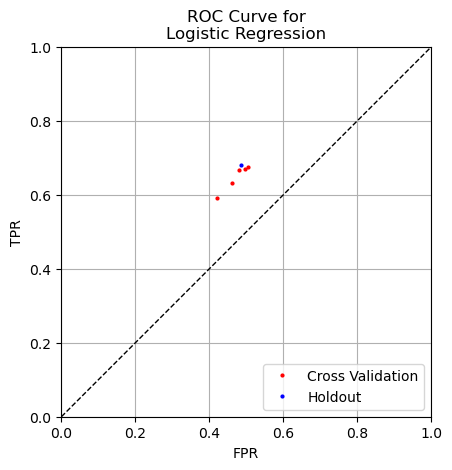

Logistic Regression (Holdout)

TP: 323
FN: 151
TN: 827
FP: 784

TPR: 0.681
FPR: 0.487

Accuracy: 0.552
Precision: 0.292
Sensitivity/Recall: 0.681
Specificity: 0.513
F1: 0.409

Logistic Regression (Cross Validation) i=4

TP: 316
FN: 158
TN: 835
FP: 776

TPR: 0.667
FPR: 0.482

Accuracy: 0.552
Precision: 0.289
Sensitivity/Recall: 0.667
Specificity: 0.518
F1: 0.404



In [34]:
set_seed()

# Using the hold out method with logistic regression
logistic_reg_ho = LogisticRegression(max_iter=10000, class_weight="balanced")
logistic_reg_ho.fit(x_train, y_train)
logistic_prediction_ho = logistic_reg_ho.predict(x_test)
logistic_cm_ho = metrics.confusion_matrix(y_test, logistic_prediction_ho)
logistic_results_ho = Results("Logistic Regression (Holdout)", logistic_reg_ho, logistic_cm_ho)

# Using the cross validation method with logistic regression
logistic_reg_cv = LogisticRegression(max_iter=10000, class_weight="balanced")
logistic_cv = cross_validate(logistic_reg_cv, x_train, y_train, cv=CV_SPLITS, return_estimator=True)
logistic_results_cv = []
logistic_max_cv = (0, 0)
for i in range(len(logistic_cv["estimator"])):
    logistic_prediction_cv = metrics.confusion_matrix(y_test, logistic_cv["estimator"][i].predict(x_test))
    logistic_results_cv.append(Results("Logistic Regression (Cross Validation) i=" + str(i), logistic_cv["estimator"][i], logistic_prediction_cv))

# Plotting ROC curve for all models
plot_roc_comparison("Logistic Regression", [logistic_results_ho], logistic_results_cv)

# Printing out summaries of the models with the best ROC co-ordinates
logistic_results_ho.summary()
find_best_roc(logistic_results_cv).summary()

### Linear Regression

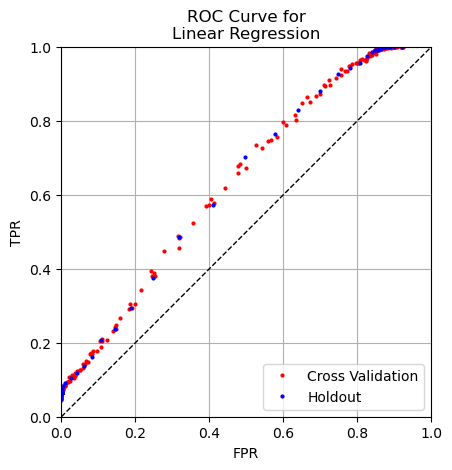

AUC: 0.566 

Linear Regression (Holdout) t=0.23

TP: 333
FN: 141
TN: 809
FP: 802

TPR: 0.703
FPR: 0.498

Accuracy: 0.548
Precision: 0.293
Sensitivity/Recall: 0.703
Specificity: 0.502
F1: 0.414

Linear Regression (Cross Validation) t=0.23, cv=2

TP: 348
FN: 126
TN: 761
FP: 850

TPR: 0.734
FPR: 0.528

Accuracy: 0.532
Precision: 0.29
Sensitivity/Recall: 0.734
Specificity: 0.472
F1: 0.416



In [35]:
set_seed()

# Variables to store results of using the hold out method with linear regression 
linear_results_ho = []
linear_reg_ho = LinearRegression()
linear_reg_ho.fit(x_train, y_train)

# Variables to store the results of using the cross validation method with linear regression 
linear_results_cv = []
linear_reg_cv = LinearRegression()
linear_cv = cross_validate(linear_reg_cv, x_train, y_train, cv=CV_SPLITS, return_estimator=True)

# Uses a binary threshold from 0.01 to 1 in steps of 0.01
for t in np.arange(0.01, 1, 0.01):
    # Adding threshold to and predicting with the hold out method
    linear_prediction_ho = apply_threshold(linear_reg_ho.predict(x_test), t)
    linear_cm_ho = metrics.confusion_matrix(y_test, linear_prediction_ho)
    linear_results_ho_curr = Results("Linear Regression (Holdout) t=" + str(round(t, 2)), linear_reg_ho, linear_cm_ho)
    linear_results_ho.append(linear_results_ho_curr)

    # Adding threshold to and predicting with each cross validation method
    for i in range(len(linear_cv["estimator"])):
        linear_prediction_cv = apply_threshold(linear_cv["estimator"][i].predict(x_test), t)
        linear_prediction_cv = metrics.confusion_matrix(y_test, linear_prediction_cv)
        linear_results_cv_curr = Results("Linear Regression (Cross Validation) t=" + str(round(t, 2)) + ", cv="+str(i), linear_cv["estimator"][i], linear_prediction_cv)
        linear_results_cv.append(linear_results_cv_curr)

# Plotting ROC curve for all models
linear_auc = plot_roc_comparison("Linear Regression", linear_results_ho, linear_results_cv)
print("AUC:", round(linear_auc, 3),"\n")

# Printing out summaries of the models with the best ROC co-ordinates
find_best_roc(linear_results_ho).summary()
find_best_roc(linear_results_cv).summary()

### Gaussian Naive Bayseian Classifier

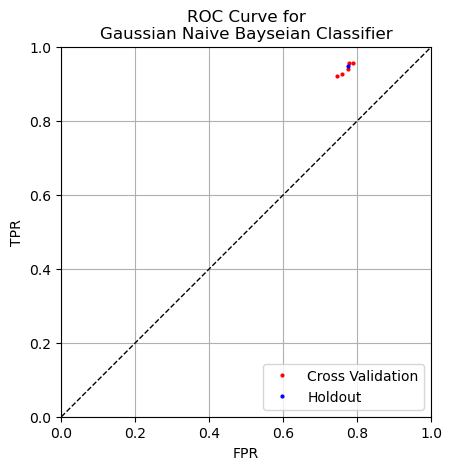

Gaussian Naive Bayseian Classifier (Holdout)

TP: 450
FN: 24
TN: 360
FP: 1251

TPR: 0.949
FPR: 0.777

Accuracy: 0.388
Precision: 0.265
Sensitivity/Recall: 0.949
Specificity: 0.223
F1: 0.414

Gaussian Naive Bayseian Classifier (Cross Validation) i=0

TP: 437
FN: 37
TN: 411
FP: 1200

TPR: 0.922
FPR: 0.745

Accuracy: 0.407
Precision: 0.267
Sensitivity/Recall: 0.922
Specificity: 0.255
F1: 0.414



In [36]:
set_seed()

# Using the hold out method with the Gaussian Naive Bayseian classifier 
gnb_reg_ho = GaussianNB()
gnb_reg_ho.fit(x_train, y_train)
gnb_prediction_ho = gnb_reg_ho.predict(x_test)
gnb_cm_ho = metrics.confusion_matrix(y_test, gnb_prediction_ho)
gnb_results_ho = Results("Gaussian Naive Bayseian Classifier (Holdout)", gnb_reg_ho, gnb_cm_ho)

# Using the cross validation method with the Gaussian Naive Bayseian classifier 
gnb_reg_cv = GaussianNB()
gnb_cv = cross_validate(gnb_reg_cv, x_train, y_train, cv=CV_SPLITS, return_estimator=True)
gnb_results_cv = []
gnb_max_cv = (0, 0)
for i in range(len(gnb_cv["estimator"])):
    gnb_prediction_cv = metrics.confusion_matrix(y_test, gnb_cv["estimator"][i].predict(x_test))
    gnb_results_cv.append(Results("Gaussian Naive Bayseian Classifier (Cross Validation) i=" + str(i), gnb_cv["estimator"][i], gnb_prediction_cv))

# Plotting ROC curve for all models
plot_roc_comparison("Gaussian Naive Bayseian Classifier", [gnb_results_ho], gnb_results_cv)

# Printing out summaries of the models with the best ROC co-ordinates
gnb_results_ho.summary()
find_best_roc(gnb_results_cv).summary()


### Decision Tree Classifier

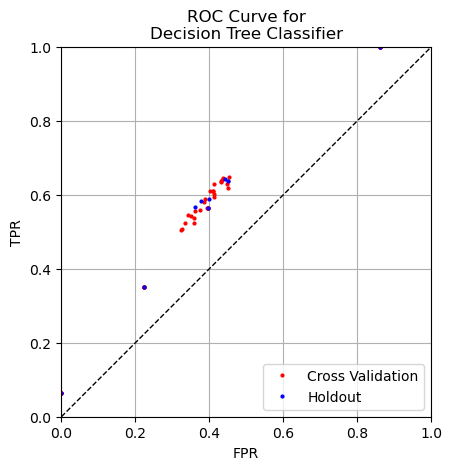

Decision Tree Classifier (Holdout) d=7

TP: 277
FN: 197
TN: 1001
FP: 610

TPR: 0.584
FPR: 0.379

Accuracy: 0.613
Precision: 0.312
Sensitivity/Recall: 0.584
Specificity: 0.621
F1: 0.407

Decision Tree Classifier (Cross Validation) cv=1, d=6

TP: 298
FN: 176
TN: 945
FP: 666

TPR: 0.629
FPR: 0.413

Accuracy: 0.596
Precision: 0.309
Sensitivity/Recall: 0.629
Specificity: 0.587
F1: 0.414



In [37]:
set_seed()

# Variables to store the results of using the hold out method with a decision tree classifier 
dt_results_ho = []
dt_models_ho = []

# Variables to store the results of using the cross validation method with a decision tree classifier 
dt_results_cv = []
dt_models_cv = []

# Using max_depth values from 1 to 5
for d in range(1, 10, 1):
    # Adding threshold to and predicting with the hold out method
    dt_reg_ho = DecisionTreeClassifier(class_weight="balanced", max_depth=d)
    dt_reg_ho.fit(x_train, y_train)
    dt_models_ho.append(dt_reg_ho)
    dt_prediction_ho = dt_reg_ho.predict(x_test)
    dt_cm_ho = metrics.confusion_matrix(y_test, dt_prediction_ho)
    dt_results_ho_curr = Results("Decision Tree Classifier (Holdout) d=" + str(d), dt_reg_ho, dt_cm_ho)
    dt_results_ho.append(dt_results_ho_curr)

    # Adding threshold to and predicting with each cross validation method
    dt_reg_cv = DecisionTreeClassifier(class_weight="balanced", max_depth=d)
    dt_cv = cross_validate(dt_reg_cv, x_train, y_train, cv=CV_SPLITS, return_estimator=True)
    dt_models_cv.extend(dt_cv)
    for i in range(len(dt_cv["estimator"])):
        dt_prediction_cv = dt_cv["estimator"][i].predict(x_test)
        dt_prediction_cv = metrics.confusion_matrix(y_test, dt_prediction_cv)
        dt_results_cv_curr = Results("Decision Tree Classifier (Cross Validation) cv=" + str(i) + ", d=" + str(d), dt_cv["estimator"][i], dt_prediction_cv)
        dt_results_cv.append(dt_results_cv_curr)

# Plotting ROC curve for all models
plot_roc_comparison("Decision Tree Classifier", dt_results_ho, dt_results_cv)

# Printing out summaries of the models with the best ROC co-ordinates
find_best_roc(dt_results_ho).summary()
find_best_roc(dt_results_cv).summary()

### Passive Aggressive Regression

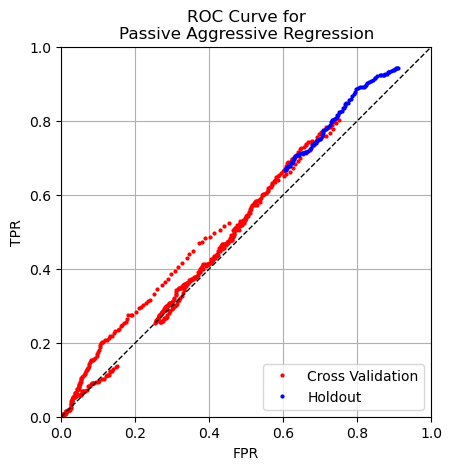

Passive Aggressive Regression (Holdout) t=0.3

TP: 420
FN: 54
TN: 326
FP: 1285

TPR: 0.886
FPR: 0.798

Accuracy: 0.358
Precision: 0.246
Sensitivity/Recall: 0.886
Specificity: 0.202
F1: 0.385

Passive Aggressive Regression (Cross Validation) t=0.08, cv=0

TP: 223
FN: 251
TN: 1011
FP: 600

TPR: 0.47
FPR: 0.372

Accuracy: 0.592
Precision: 0.271
Sensitivity/Recall: 0.47
Specificity: 0.628
F1: 0.344



In [38]:
set_seed()

# Variables to store results of using the hold out method with passive aggressive regression
pass_agg_results_ho = []
pass_agg_reg_ho = PassiveAggressiveRegressor()
pass_agg_reg_ho.fit(x_train, y_train)

# Variables to store results of using the cross validation method with passive aggressive regression
pass_agg_results_cv = []
pass_agg_reg_cv = PassiveAggressiveRegressor()
pass_agg_cv = cross_validate(pass_agg_reg_cv, x_train, y_train, cv=CV_SPLITS, return_estimator=True)

# Uses a binary threshold from 0.01 to 1 in steps of 0.01
for t in np.arange(0.01, 1, 0.01):
    # Adding threshold to and predicting with the hold out method
    pass_agg_prediction_ho = apply_threshold(pass_agg_reg_ho.predict(x_test), t)
    pass_agg_cm_ho = metrics.confusion_matrix(y_test, pass_agg_prediction_ho)
    pass_agg_results_ho_curr = Results("Passive Aggressive Regression (Holdout) t=" + str(round(t, 2)), pass_agg_reg_ho, pass_agg_cm_ho)
    pass_agg_results_ho.append(pass_agg_results_ho_curr)

    # Adding threshold to and predicting with each cross validation method
    for i in range(len(pass_agg_cv["estimator"])):
        pass_agg_prediction_cv = apply_threshold(pass_agg_cv["estimator"][i].predict(x_test), t)
        pass_agg_prediction_cv = metrics.confusion_matrix(y_test, pass_agg_prediction_cv)
        pass_agg_results_cv_curr = Results("Passive Aggressive Regression (Cross Validation) t=" + str(round(t, 2)) + ", cv="+str(i), pass_agg_cv["estimator"][i], pass_agg_prediction_cv)
        pass_agg_results_cv.append(pass_agg_results_cv_curr)

# Plotting ROC curve for all models
pass_agg_auc = plot_roc_comparison("Passive Aggressive Regression", pass_agg_results_ho, pass_agg_results_cv)

# Printing out summaries of the models with the best ROC co-ordinates
find_best_roc(pass_agg_results_ho).summary()
find_best_roc(pass_agg_results_cv).summary()

### K Nearest Neighbours

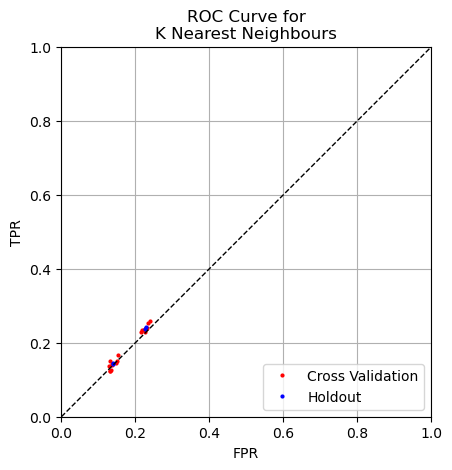

K Nearest Neighbours (Holdout) k=1

TP: 115
FN: 359
TN: 1244
FP: 367

TPR: 0.243
FPR: 0.228

Accuracy: 0.652
Precision: 0.239
Sensitivity/Recall: 0.243
Specificity: 0.772
F1: 0.241

K Nearest Neighbours (Cross Validation) cv=1, k=1

TP: 123
FN: 351
TN: 1224
FP: 387

TPR: 0.259
FPR: 0.24

Accuracy: 0.646
Precision: 0.241
Sensitivity/Recall: 0.259
Specificity: 0.76
F1: 0.25



In [39]:
set_seed()

# Variables to store the results of using the hold out method with k nearest neighbours 
k_nearest_results_ho = []
k_nearest_models_ho = []

# Variables to store the results of using the cross validation method with k nearest neighbours 
k_nearest_results_cv = []
k_nearest_models_cv = []

# Using k values from 1 to 5
for k in range(1, 5, 1):
    # Adding threshold to and predicting with the hold out method
    k_nearest_reg_ho = KNeighborsClassifier(n_neighbors = k, weights="distance", p=1)
    k_nearest_reg_ho.fit(x_train, y_train)
    k_nearest_models_ho.append(k_nearest_reg_ho)
    k_nearest_prediction_ho = k_nearest_reg_ho.predict(x_test)
    k_nearest_cm_ho = metrics.confusion_matrix(y_test, k_nearest_prediction_ho)
    k_nearest_results_ho_curr = Results("K Nearest Neighbours (Holdout) k=" + str(k), k_nearest_reg_ho, k_nearest_cm_ho)
    k_nearest_results_ho.append(k_nearest_results_ho_curr)

    # Adding threshold to and predicting with each cross validation method
    k_nearest_reg_cv = KNeighborsClassifier(n_neighbors = k, weights="distance", p=1)
    k_nearest_cv = cross_validate(k_nearest_reg_cv, x_train, y_train, cv=CV_SPLITS, return_estimator=True)
    k_nearest_models_cv.extend(k_nearest_cv)
    for i in range(len(k_nearest_cv["estimator"])):
        k_nearest_prediction_cv = k_nearest_cv["estimator"][i].predict(x_test)
        k_nearest_prediction_cv = metrics.confusion_matrix(y_test, k_nearest_prediction_cv)
        k_nearest_results_cv_curr = Results("K Nearest Neighbours (Cross Validation) cv=" + str(i) + ", k=" + str(k), k_nearest_cv["estimator"][i], k_nearest_prediction_cv)
        k_nearest_results_cv.append(k_nearest_results_cv_curr)

# Plotting ROC curve for all models
plot_roc_comparison("K Nearest Neighbours", k_nearest_results_ho, k_nearest_results_cv)

# Printing out summaries of the models with the best ROC co-ordinates
find_best_roc(k_nearest_results_ho).summary()
find_best_roc(k_nearest_results_cv).summary()